In [3]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def load_captcha_images(data_dir):
    images = []
    labels = []
    for img_name in os.listdir(data_dir):
        img_path = os.path.join(data_dir, img_name)
        
        if not img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            continue
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            print(f"Warning: Couldn't load image {img_name}. Skipping.")
            continue
        
        try:
            img = cv2.resize(img, (128, 128))
        except Exception as e:
            print(f"Error resizing image {img_name}: {e}")
            continue
        images.append(img)
        label = os.path.splitext(img_name)[0]
        labels.append(label)

    return np.array(images), np.array(labels)


data_dir = '../../data/captchas_dataset_1/large-captcha-dataset/Large_Captcha_Dataset'
images, labels = load_captcha_images(data_dir)

print(f"Loaded {len(images)} images and {len(labels)} labels")

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: '../../data/captchas_dataset_1/large-captcha-dataset/Large_Captcha_Dataset'

In [24]:
images.shape, labels.shape

((82328, 128, 128), (82328,))

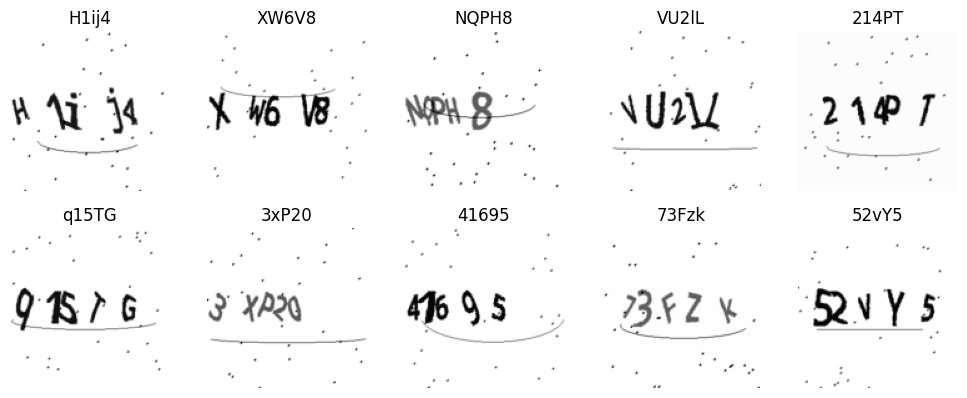

In [31]:
def show_sample_images(images, labels, num_samples=10):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(images, labels, num_samples=10)

In [32]:
images.shape, labels.shape

((82328, 128, 128), (82328,))

In [35]:
class CAPTCHA_CNN(nn.Module):
    def __init__(self, captcha_length=5, num_classes=36):
        super(CAPTCHA_CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, captcha_length * num_classes)
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))
        
        x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))
        x = self.pool(nn.ReLU()(self.bn3(self.conv3(x))))
        
        x = self.pool(nn.ReLU()(self.bn4(self.conv4(x))))
        x = self.global_avg_pool(x)
        
        x = x.view(-1, 512)
        
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x.view(-1, 5, 36)


model = CAPTCHA_CNN(captcha_length=5, num_classes=36).to(device)

In [36]:
from tqdm import tqdm

def encode_label(label, max_length=5):
    characters = '0123456789abcdefghijklmnopqrstuvwxyz'
    encoded = np.zeros(max_length, dtype=int)
    for i, char in enumerate(label):
        encoded[i] = characters.index(char.lower())
    return encoded


encoded_labels = np.array([encode_label(label) for label in y_train])
encoded_test_labels = np.array([encode_label(label) for label in y_test])

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(encoded_labels, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(encoded_test_labels, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = CAPTCHA_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
model.train()
for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    
    train_loader_tqdm = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
    
    for inputs, targets in train_loader_tqdm:
        optimizer.zero_grad()
        targets = targets.to(device)
        inputs = inputs.to(device)
        outputs = model(inputs)
        loss = 0
        cnt = 0
        for i in range(5):
            loss += criterion(outputs[:, i, :], targets[:, i])
        
        loss.backward()
        optimizer.step()
        
        train_loader_tqdm.set_postfix(loss=loss.item())

In [37]:
X_test_tensor.shape, y_test_tensor.shape

(torch.Size([16466, 1, 128, 128]), torch.Size([16466, 5]))

In [38]:
def decode_predictions(predictions, max_length=5):
    characters = '0123456789abcdefghijklmnopqrstuvwxyz'
    decoded = []
    for pred in predictions:
        captcha = ''
        for i in range(max_length):
            index = pred[i].argmax(dim=-1).item()
            captcha += characters[index]
        decoded.append(captcha)
    return decoded


def calculate_accuracy(model, data_loader):
    model.eval()
    correct_captchas = 0
    total_captchas = 0
    correct_characters = 0
    total_characters = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            decoded_preds = decode_predictions(outputs)
            decoded_targets = [encode_label_to_string(t) for t in targets]

            for pred, target in zip(decoded_preds, decoded_targets):
                if total_captchas < 20:
                    print(pred, target)
                if pred == target:
                    correct_captchas += 1
                correct_characters += sum([p == t for p, t in zip(pred, target)])
                total_captchas += 1
                total_characters += len(target)

    captcha_accuracy = correct_captchas / total_captchas * 100
    character_accuracy = correct_characters / total_characters * 100

    print(f'Captcha Accuracy: {captcha_accuracy:.2f}%')
    print(f'Character Accuracy: {character_accuracy:.2f}%')
    return captcha_accuracy, character_accuracy


def encode_label_to_string(label):
    characters = '0123456789abcdefghijklmnopqrstuvwxyz'
    return ''.join([characters[idx] for idx in label])


test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)
captcha_accuracy, character_accuracy = calculate_accuracy(model, test_loader)

23323 2ux13
y6646 1y46y
666u6 3pu60
zzwzz e4w6z
9999s 2s92v
44444 4mmp4
161w6 6p1w5
nnnnn nn8rz
55555 73535
88888 816om
44446 4w665
78787 7r98p
66661 h16ua
g1111 bg10n
44444 ryk4n
99629 30269
33333 13bf3
99928 82r92
99nss 9pnss
mmmww dwmzt
Captcha Accuracy: 0.00%
Character Accuracy: 24.46%
